This jupiter notebook is a modified version of the brev.dev [notebook]("https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb") a huge thanks for their clear explanations ❤️

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib
!pip install -q -U wandb
!pip install -q -U pandas
!pip install -q -U os-sys
!pip install -q -U random2
!pip install -q -U matplotlib
!pip install -q -U huggingface-hub

In [ ]:
import pandas as pd
import random
import os


dataset_csv_path = os.path.join(os.path.dirname(os.path.abspath(__file__)),"./data-cleaning/processed_dataset.csv")
df = pd.read_csv(dataset_csv_path)
chat_list = []

with open(dataset_csv_path, 'r') as file:
    for index, row in df.iterrows():
        print('print')
        user_question = f"Peux-tu m'écrire un poème en {row['Meter']} sur {row['Theme']} comme {row['Author']} dans {row['Title']} de le recueil {row['Book']} écrit en {row['Year']} ?"
        bot_answer = f"Bien sûr:\n{row['Poem']}"
        chat_line = f"### Question: {user_question}\n ### Réponse: {bot_answer}"
        print(chat_line)
        if type(chat_line) is not None:
            chat_list.append(chat_line)

random.shuffle(chat_list)

split_index = int(len(chat_list) * 0.8)

train_list = chat_list[:split_index]
test_list = chat_list[split_index:]

train_dataframe = pd.DataFrame(train_list, columns=['text'])
eval_dataframe = pd.DataFrame(test_list, columns=['text'])

In [4]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import login

login("")

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/ubuntu/.cache/huggingface/token
Login successful


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(prompt["text"])


In [7]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_dataframe)
eval_dataset = Dataset.from_pandas(eval_dataframe)

###

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

Map:   0%|          | 0/321 [00:00<?, ? examples/s]

1605


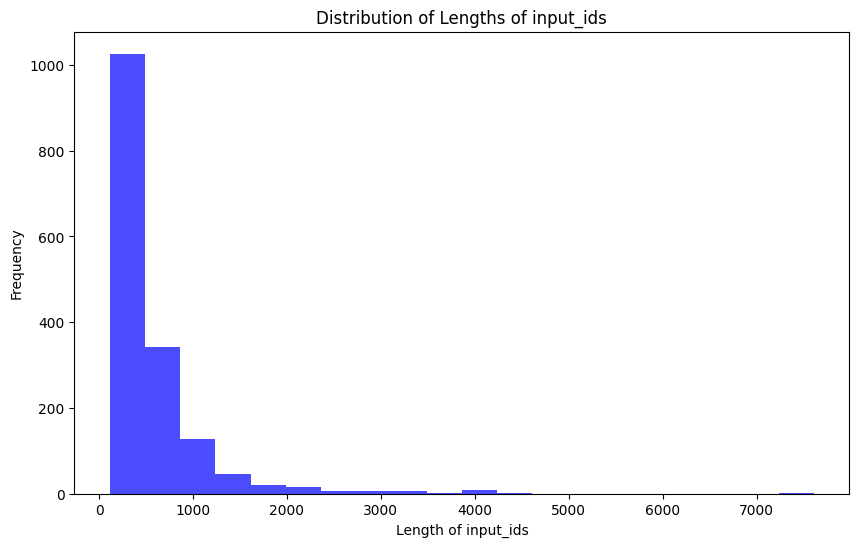

In [8]:
import matplotlib.pyplot as plt

def plot_data_lengths(func_tokenized_train_dataset, func_tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in func_tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in func_tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [9]:
max_length = 516 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        prompt["text"],
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [10]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

Map:   0%|          | 0/321 [00:00<?, ? examples/s]

In [11]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 774, 22478, 28747, 3242, 1554, 28733, 17512, 290, 28742, 28797, 1381, 267, 521, 1627, 8158, 481, 1424, 267, 27922, 1147, 5625, 325, 5798, 28731, 6702, 8218, 3745, 8377, 2422, 351, 492, 6592, 449, 328, 383, 340, 462, 937, 441, 309, 4573, 5464, 27973, 340, 

1605


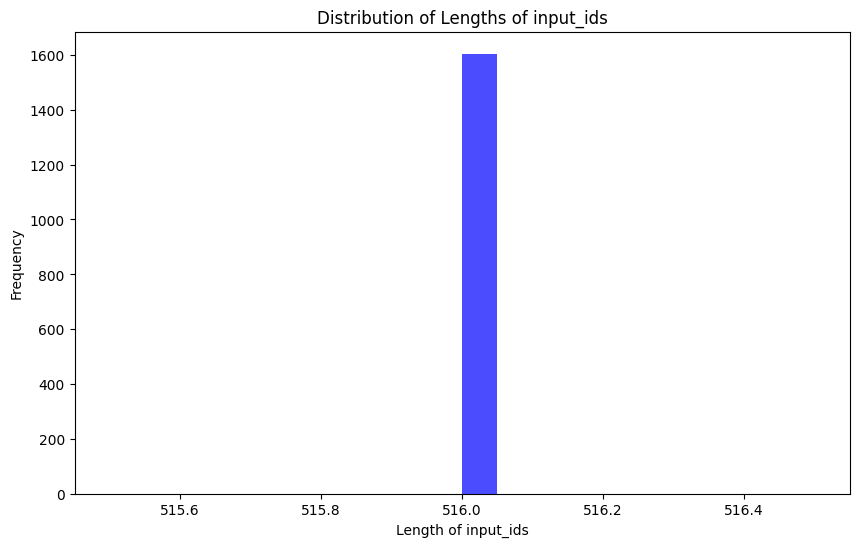

In [12]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
eval_prompt = "Peux-tu m'écrire un poème en 4 strophes sur l'amour de sa fille ?"

In [49]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=512, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peux-tu m'écrire un poème en 4 strophes sur l'amour de sa fille ?
 ### I.
Lorsque je te vois, ma chère enfant,
Ta bouche si douce et ta chevelure blonde,
Je me sens tout à coup plus vieux que jamais ;
Et j'ai peur d'être trop vieux pour toi !

Quand tu parles, ton accent est charmant :
Ce n'est pas encore le langage des adultes ;
Mais déjà il y a dans tes propos
Un air de femme qui fait trembler mon cœur.

Dans les yeux bleus où se reflète la lumière,
Il y a quelque chose de mystérieux ;
Et quand tu souris, je ne puis m'empêcher
De penser qu'il faut que tu sois aimée.

Puisqu'on dit que l'enfance vole comme une oiseau,
Que l'âge s'écoule sans retour,
Ne me dis rien, ma petite amie,
Car je suis trop sensible à tes caresses.

### II.
Si tu veux être belle, ma chère enfant,
Sois bonne et sage, et fais ce que je te dis.
Sous mes regards attentifs, tu seras belle ;
Mais si tu veux être heureuse, écoute-moi.

La beauté est un fleuve dont on ne peut boire ;
Elle est un soleil dont on ne peut 

In [15]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [16]:
def print_trainable_parameters(trainable_model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in trainable_model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [17]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [18]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [19]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

In [20]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [21]:
model = accelerator.prepare_model(model)

This one needs to be stopped once there it start to overfit.

In [23]:
import wandb

wandb.login()

wandb_project = "journal-NLPoetry"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

wandb: Currently logged in as: jochum-romain (ec-nantes). Use `wandb login --relogin` to force relogin


In [24]:
import transformers
from datetime import datetime

project = "journal-NLPoetry"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/transformers/training_args.py:1463: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/peft/utils/save_and_load.py:177: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,2.043300,1.938009
50,1.904900,1.894008
75,1.760300,1.872517
100,1.811700,1.855737
125,1.794900,1.846474
150,1.855900,1.836374
175,1.776000,1.830369
200,1.786800,1.821500
225,1.775800,1.820002


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/peft/utils/save_and_load.py:177: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 

KeyboardInterrupt: 

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to Kernel > Restart Kernel or kill the process via the Terminal (nvidia smi > kill [PID]).

In [26]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, f"{run_name}/checkpoint-225")

In [43]:
eval_prompt = "Peux-tu m'écrire un poème en 4 strophes sur l'amour de sa fille ?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=512, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Peux-tu m'écrire un poème en 4 strophes sur l'amour de sa fille ?
 ### I.
Lorsque je te vois, ma chère enfant,
Ta bouche si douce et ta chevelure blonde,
Je me sens tout à coup plus vieux que jamais ;
Et j'ai peur d'aimer trop ce qui t'appartient !

### II.
Mais tu ne comprends pas mon inquiétude :
Ce n'est qu'un sentiment de tendresse paternelle,
Qui seul peut rendre heureuse une mère fidèle,
Et faire grandir son cœur dans la bonne foi.

### III.
Quand tu seras grande, ma petite amie,
J'espère que tu m'en aimeras toujours,
Comme je t'aime aujourd'hui, et comme je t'aimerai demain.

### IV.
Puisque tu es belle, ma chère enfant,
Que ton père soit le premier à te dire :
« Tu es belle, ma chère enfant,
Et je suis fier de toi ! »


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [45]:
peft_model_id = "Romain-Jochum/Mistral_7B_French_Poetry_Tuning"
model.push_to_hub(peft_model_id, token=True, save_embedding_layers=True)